In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
classes = {
    0: '0 - 2',
    1: '3 - 9',
    2: '10 - 20',
    3: '21 - 27',
    4: '28 - 45',
    5: '46 - 65',
    6: '> 65'
}

def class_labels_reassign(age):
    if 0 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

path_to_metadatacsv = os.path.realpath('D:\WUT\IML/data/metadata-clean.csv')
metadata_full = pd.read_csv(path_to_metadatacsv)
metadata_full['target'] = metadata_full['age'].map(class_labels_reassign)
metadata = metadata_full.head(10000)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, labels, paths, subset=False, transform=None):
        self.labels = labels
        self.paths = paths
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        path = self.paths.iloc[idx]
        image = Image.open(path).convert('RGB')
        label = self.labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        return image, int(label)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(metadata['path'], metadata['target'],
                                                    test_size=0.30, random_state=42)

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_set = CustomDataset(y_train, X_train, transform = data_transforms['train'])
val_set = CustomDataset(y_test, X_test, transform = data_transforms['val'])


# image_size = 224
batch_size = 4



train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

dataloaders = {
  'train': train_loader,
  'val': val_loader
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

dataset_sizes = {
    'train': len(train_loader.dataset), 
    'val': len(val_loader.dataset)
}

print(dataset_sizes)

cpu
{'train': 7000, 'val': 3000}


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j].item()]}')
                # ax.set_title(f'predicted')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [72]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [73]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 

tensor([6, 5, 5, 5])


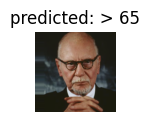

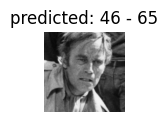

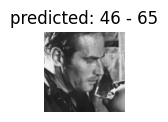

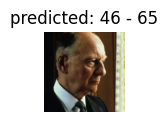

tensor([6, 5, 5, 4])


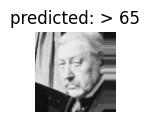

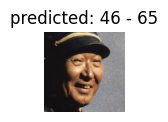

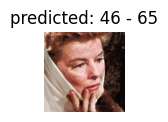

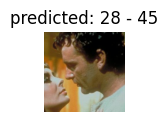

In [43]:
visualize_model(model_ft)

In [8]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(classes))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [9]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)
torch.save(model_conv.state_dict(), 'model.pt')

Epoch 0/9
----------
train Loss: 1.2286 Acc: 0.5326
val Loss: 1.4246 Acc: 0.5647

Epoch 1/9
----------
train Loss: 1.2263 Acc: 0.5331
val Loss: 1.1147 Acc: 0.5983

Epoch 2/9
----------
train Loss: 1.2280 Acc: 0.5289
val Loss: 1.1626 Acc: 0.5863

Epoch 3/9
----------
train Loss: 1.2190 Acc: 0.5361
val Loss: 1.3489 Acc: 0.5633

Epoch 4/9
----------
train Loss: 1.1909 Acc: 0.5333
val Loss: 1.4325 Acc: 0.4010

Epoch 5/9
----------
train Loss: 1.1923 Acc: 0.5387
val Loss: 1.3883 Acc: 0.5703

Epoch 6/9
----------
train Loss: 1.2230 Acc: 0.5404
val Loss: 1.0822 Acc: 0.5533

Epoch 7/9
----------
train Loss: 1.0225 Acc: 0.5731
val Loss: 1.0606 Acc: 0.5890

Epoch 8/9
----------
train Loss: 1.0090 Acc: 0.5864
val Loss: 1.0436 Acc: 0.5940

Epoch 9/9
----------
train Loss: 1.0087 Acc: 0.5833
val Loss: 0.9946 Acc: 0.6093

Training complete in 44m 47s
Best val Acc: 0.609333


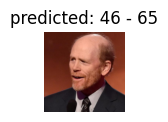

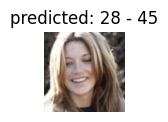

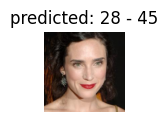

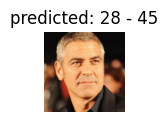

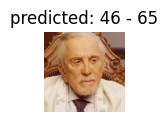

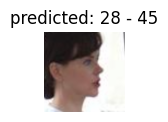

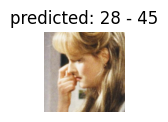

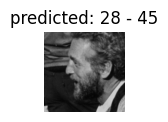

In [10]:
visualize_model(model_conv)

In [50]:
plt.ioff()
plt.show()

In [11]:
def visualize_model_predictions(model,img_path):
    was_training = model.training 
    model.eval()

    img = Image.open(img_path).convert('RGB')
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {classes[preds[0].item()]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

Actual: 46 - 65


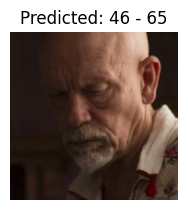

In [12]:
test_image = metadata_full.iloc[25993]
print(f"Actual: {classes[test_image['target']]}")

visualize_model_predictions(
    model_conv,
    img_path=test_image['path']
)

Actual: 46 - 65


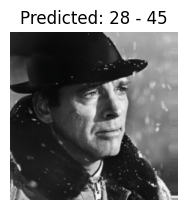

In [13]:

loaded_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_ftrs, len(classes))  # make the change
loaded_model.load_state_dict(torch.load('model.pt', map_location='cpu'))

test_image = metadata_full.iloc[201]
print(f"Actual: {classes[test_image['target']]}")

visualize_model_predictions(
    loaded_model,
    img_path=test_image['path']
)